# KNR ROBOBUDEX

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import ecoinfo
from rules import *
import rasterio

test
Rule more renewable: tensor([ 0.3727, -0.5487,  0.1440])
Rule more fiber optics: tensor([ 0.0890, -0.1390,  0.0200])
Rule heating region: tensor([-3.3000,  7.3000, -3.0000])
Rule facilities: tensor([   0., -138.,    0.])
Rule possible heat: tensor([-0.4840, -6.2460,  3.0410])
Rule good solar: tensor([ 0.4870, -0.1270, -0.3000])
Rule high wind: tensor([0., 0., 0.])
Total rule score: tensor([-0.7390, -1.0278,  0.0122])


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

### DATASET & DATALOADER

In [3]:
class USADataset(Dataset):
    def __init__(self):
        self.sampling_lat = 200
        self.sampling_lon = 400 
        self.lendata = 0
        self.data = self.generate_data()
        
        

    def generate_data(self):
        latitudes = torch.linspace(25.0, 49.5, self.sampling_lat)
        longtitudes = torch.linspace(-125.0, -67.0, self.sampling_lon)
        data = torch.zeros((self.sampling_lat * self.sampling_lon, 7), dtype=torch.float32)
        sample_idx = 0
        raster_map = ecoinfo.get_default_params_map()

        df_data = ecoinfo.extract_multiple_to_df(raster_map, [(lat, lon) for lat in latitudes for lon in longtitudes])
        while sample_idx < len(df_data):
            row = df_data.iloc[sample_idx]
            data[sample_idx, 0:] = torch.tensor([
                row["lat"],
                row["lon"],  
                row["Wind efficiency"],
                row["Solar power"],
                row["Fiber optics"],
                row["Temperature"],
                row["Popilation density"]
            ], dtype=torch.float32)
            sample_idx += 1

        self.lendata = sample_idx
        data=data[0:self.lendata,:]
        return data
                
                    
        
    def __len__(self):
        return self.lendata

    def __getitem__(self, idx):
        return self.data[idx,:]
        
dataset = USADataset()      


In [4]:
torch.save(dataset.data, "usa_dataset_200_400.pt")

In [5]:
class USADatasetLoaded(Dataset):
    def __init__(self, path):
        self.data = torch.load(path).data    
        self.lendata = self.data.shape[0]

    def __len__(self):
        return self.lendata

    def __getitem__(self, idx):
        return self.data[idx, :]      

In [6]:
dataset = USADatasetLoaded("usa_dataset_200_400.pt")

In [7]:
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)
print(f"DATASET SHAPE: {len(dataset)}")

DATASET SHAPE: 45779


In [8]:
print(next(iter(dataloader)))

tensor([[ 2.7216e+01, -8.1682e+01,  3.3524e+01,  4.4760e+00,  3.0566e-01,
          2.2900e+01,  1.7489e+00],
        [ 3.8912e+01, -1.1991e+02,  5.0948e+00,  5.1410e+00,  4.1097e-01,
          2.2000e+00,  0.0000e+00],
        [ 4.7530e+01, -1.0945e+02,  1.3049e+02,  4.1520e+00,  2.0057e-01,
          7.3000e+00,  4.4090e-02],
        [ 3.6450e+01, -8.9677e+01,  6.2268e+01,  4.1340e+00,  3.1495e-01,
          1.5700e+01,  7.2604e+00],
        [ 4.2975e+01, -1.0349e+02,  1.0423e+02,  4.5060e+00,  2.1573e-01,
          9.4000e+00,  0.0000e+00],
        [ 3.7681e+01, -8.6188e+01,  2.9339e-03,  3.9440e+00,  3.5097e-01,
          1.4300e+01,  1.1544e+01],
        [ 3.8543e+01, -8.6043e+01,  4.3298e+01,  3.9260e+00,  4.6912e-01,
          1.3100e+01,  4.3656e+01],
        [ 4.4698e+01, -1.1017e+02,  6.3171e+01,  4.4350e+00,  2.1920e-01,
          3.0000e-01,  0.0000e+00],
        [ 4.8023e+01, -1.0916e+02,  1.2577e+02,  4.1350e+00,  2.0059e-01,
          6.6000e+00,  0.0000e+00],
        [ 

### MODEL

In [9]:
input_dim = 7
lr = 1e-4
epochs = 80

In [10]:
def ranknet_loss(score_a, score_b, S):
    """
    score_a, score_b: predicted scores for pairs
    S: target preference (+1 if a > b, -1 if a < b)
    """
    pred = torch.sigmoid(score_a - score_b)
    target = (S + 1) / 2
    loss = nn.BCELoss()(pred, target, )
    return loss


def generate_pairs(batch):
    """
    Generates all pairs from a batch (a,b) for ranking.
    """
    xa = batch.unsqueeze(1).repeat(1, batch.size(0), 1)  # [B,B,F]
    xb = batch.unsqueeze(0).repeat(batch.size(0), 1, 1)  # [B,B,F]

    # Only take upper triangular pairs to avoid duplicates and self-pairs
    mask = torch.triu(torch.ones(xa.shape[0], xa.shape[1]), diagonal=1).bool()
    xa_pairs = xa[mask]
    xb_pairs = xb[mask]
    return xa_pairs, xb_pairs



In [11]:
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)

model = RankNet(input_dim=input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# training loop

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        
        xa, xb = generate_pairs(batch)
        
        S = total_rule_score(xa, xb, N=5)
        S = S.unsqueeze(1)
        S_binary = torch.sign(S).clamp(min=-1.0, max=1.0)
        
        score_a = model(xa)
        score_b = model(xb)
        
        loss = ranknet_loss(score_a, score_b, S_binary)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    scheduler.step()

    if (epoch%10 == 0):
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

        #test:
        with torch.no_grad():
            batch = batch.to(device)
        
            xa, xb = generate_pairs(batch)
            
            S = total_rule_score(xa, xb, N=7)
            S = S.unsqueeze(1)
            S_binary = torch.sign(S).clamp(min=-1.0, max=1.0)
            
            score_a = model(xa)
            score_b = model(xb)
            
            loss = ranknet_loss(score_a, score_b, S_binary).item()
            
            print(f" Test Loss (all rules): {loss:.4f}")   
            

Epoch 1/80, Loss: 0.4825
 Test Loss (all rules): 0.3328
Epoch 11/80, Loss: 0.3491
 Test Loss (all rules): 0.2447
Epoch 21/80, Loss: 0.3316
 Test Loss (all rules): 0.2462
Epoch 31/80, Loss: 0.3228
 Test Loss (all rules): 0.2277
Epoch 41/80, Loss: 0.3281
 Test Loss (all rules): 0.2130
Epoch 51/80, Loss: 0.3195
 Test Loss (all rules): 0.2574
Epoch 61/80, Loss: 0.3289
 Test Loss (all rules): 0.2581
Epoch 71/80, Loss: 0.3354
 Test Loss (all rules): 0.1994


In [12]:
torch.save(model.state_dict(), "usa_model_200_400.pt")

In [13]:
model = RankNet(input_dim=input_dim)
model.load_state_dict(torch.load("usa_model_200_400.pt", map_location="cpu"))
model.eval()

RankNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [14]:
data_tensor = dataset.data 

with torch.no_grad():
    predictions = model(data_tensor).squeeze().numpy()

latitudes = data_tensor[:, 0].numpy()
longitudes = data_tensor[:, 1].numpy()
    

In [16]:
import matplotlib
matplotlib.use("Agg")   # non-interactive backend
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Define regular grid
grid_lon = np.linspace(-125, -67, 80)
grid_lat = np.linspace(25, 50, 40)
grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

plt.figure(figsize=(14, 8))

grid_pred = griddata(
    points=np.column_stack((longitudes, latitudes)),
    values=predictions,
    xi=(grid_lon2d, grid_lat2d),
    method="nearest"   # instead of "linear"
)
grid_pred = np.ma.masked_invalid(grid_pred)
img = plt.imshow(grid_pred, extent=[-125,-67,25,50], origin="lower", alpha=0.8)



plt.colorbar(img, label="Predicted Score", shrink=0.7)
plt.title("Model Predictions Across USA")

plt.savefig("usa_predictions_map.png", dpi=220)
print("Saved: usa_predictions_map.png")

Saved: usa_predictions_map.png


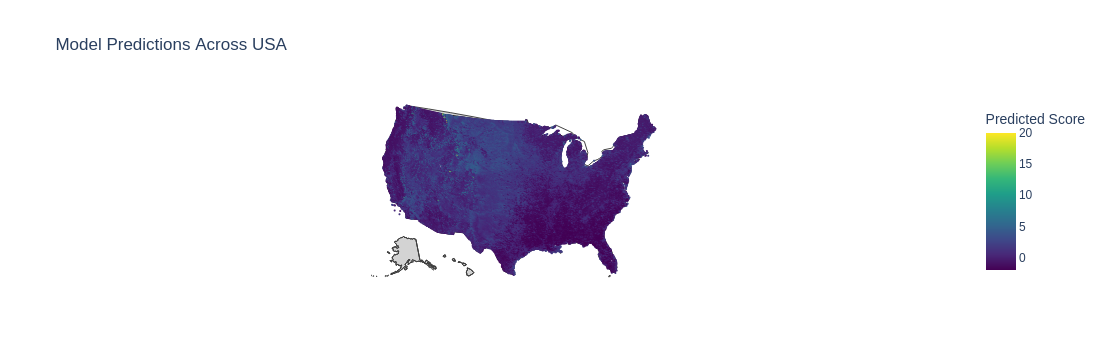

In [22]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np

# Włączamy Plotly w Jupyter Notebook
init_notebook_mode(connected=True)

# Przykładowe dane (zamień na swoje)
# longitudes = np.array([...])
# latitudes = np.array([...])
# predictions = np.array([...])

# Tworzymy scatter plot
scatter = go.Scattergeo(
    lon=longitudes,
    lat=latitudes,
    text=[f"Score: {v:.2f}" for v in predictions],  # etykieta przy hover
    marker=dict(
        size=2,
        color=predictions,
        cmin=-2,
        cmax=20,   
        colorscale='Viridis',
        colorbar=dict(title='Predicted Score'),
        line=dict(width=0)
    ),
    mode='markers'
)

# Układ mapy
layout = go.Layout(
    title='Model Predictions Across USA',
    geo=dict(
        scope='usa',             # pokazujemy tylko USA
        projection=dict(type='albers usa'),
        showland=True,
        landcolor='lightgray',
        showcountries=True,
        showsubunits=True,       # pokazuje kontury stanów
        subunitcolor='black'     # kolor konturów stanów
    )
)

fig = go.Figure(data=[scatter], layout=layout)

# Wyświetlamy w notebooku
iplot(fig)
